<a href="https://colab.research.google.com/github/CamelGoong/DataScienceLab/blob/main/CNN_%EC%A0%9C_1%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이 노트북은 최건호, 파이토치 첫걸음 , 한빛미디어 ,2019 를 참고하였습니다. 

## 1. 모듈 불러오기

In [1]:
import torch 
import torch.nn as nn #많은 neural network이 담겨있는 모듈입니다. 
import torch.optim as optim  # 많은 optimizer가 담겨있는 모듈입니다. 
import torch.nn.init as init # neural network를 초기화 하는 모듈을 담고 있습니다. 
from torch.utils.data import DataLoader # DataLoader는 내가 가진 데이터(Dataset에서)를 batch_size만큼 불러오는 역할 등을 수행합니다. 

import torchvision # 이미지를 처리하는데 사용 
import torchvision.datasets as dset # 사진 등의 vision 데이터가 담겨있는 모듈입니다. 
import torchvision.transforms as transforms #이 모듈에는 데이터를 자르고, 반전시키고 tensor로 변환해주기 등의 데이터 변환 함수가 담겨있습니다.
import numpy as np

import matplotlib.pyplot as plt

print(torch.__version__)


1.9.0+cu102


## 2. 데이터 다운 

In [2]:
#모듈을 통해 torchvision.datasets에서 제공하는 데이터를 쉽게 다운받을 수 있습니다. 
#root는 불러들인 데이터가 저장되는 곳, train은 학습데이터인지에 대한 여부, transform은 데이터 변환함수를 넣는 인자, 
#target_transform은 label(정답)데이터 또한 변환할 것인지에 대한 여부 
#download는 지정된 경로에 데이터가 없다면 다운받을 것인지에 대한 여부를 묻습니다. 
mnist_train=dset.MNIST(root='../',train=True, transform=transforms.ToTensor(),target_transform=None,download=True)
mnist_test=dset.MNIST(root='../',train=False,transform=transforms.ToTensor(),target_transform=None,download=True)


Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../MNIST/raw/train-images-idx3-ubyte.gz to ../MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../MNIST/raw/train-labels-idx1-ubyte.gz to ../MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../MNIST/raw/t10k-images-idx3-ubyte.gz to ../MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../MNIST/raw/t10k-labels-idx1-ubyte.gz to ../MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:

#데이터 셋 체크 getitem을 써도 되고, 인덱싱을 통해서 해도 괜찮습니다. 
#데이터 하나가 가진 크기를 유심히 봐야합니다. 
print(mnist_train.__getitem__(0)[0].size(), mnist_train.__len__())
print(mnist_test.__getitem__(0)[0].size(), mnist_test.__len__())

print(len(mnist_train),len(mnist_test))
#print(mnist_train[0])


torch.Size([1, 28, 28]) 60000
torch.Size([1, 28, 28]) 10000
60000 10000


## 3. 하이퍼 파라미터 

In [4]:
#CNN에서 대표적인 하이퍼 파라미터로는  num_epoch, batch_size, learnin_rate가 있습니다. 이는 모델에 따라 가감될 수 있습니다. 
num_epoch=10
batch_size=256
learning_rate= 0.0002

## 4. 데이터 로더 정의하기 

- 사용할 데이터
- 배치 사이즈 (batch_size)
- 섞을지 여부 (shuffle)
- 사용할 프로세스 개수 (num_workers)
- 마지막에 남는 데이터의 처리 여부 (drop_last)

In [5]:
#위에서 데이터를 정의했는데 왜 또 데이터를 정의하나요? 라는 의문이 생길 것 같습니다. 
#위에서는 데이터 전부를 정의했습니다. mnist_train에는 모든 학습 데이터가 들어있습니다.
#모든 학습 데이터를 한 번에 학습하면 과부하가 발생할 것입니다. 
#그래서 데이터를 '조금씩 조금씩 쪼개서 학습'할 필요가 있습니다. 그 역할을 수행하는 것이 'DataLodaer'이고 때문에 여기서 train_loader,text_loader를 정의하는 것입니다. 
train_loader=DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True,num_workers=2,drop_last=True)
test_loader=DataLoader(dataset=mnist_test,batch_size=batch_size,shuffle=False,num_workers=2,drop_last=True)


## 5. 모델 정의하기 

In [9]:
#모델을 정의할 때 유념해야할 건 각 층의 결과물의 사이즈입니다. 
#이 층에서 어떤 size를 가진 데이터를 몇 개 도출하는지 정확하게 알고 있어야 정확한 모델을 정의할 수 있습니다. 
#모델이 복잡해지면 복잡해질수록 이는 더욱 중요해집니다. 때문에 모델을 정의할 때 옆에 각 모델이 도출하는 데이터의 크기를 써넣는 것을 추천드립니다. 
#해당 모델은 임의로 만든 모델입니다. 이 모델이 다른 모델보다 뛰어나다는 보장이 없습니다. 
class CNN(nn.Module):   
  def __init__(self):
    super(CNN,self).__init__()                                      #처음에 채널의 수가 1인 이유: 흑백이미지이기 때문입니다. 
    self.layer=nn.Sequential(                                      #input_size=[batch_size, 1,28,28]  #4차원 tensor
        nn.Conv2d(in_channels=1,out_channels=16, kernel_size=5),   #[batch_size, 16,24,24]
        nn.ReLU(),                                                 #activation function은 데이터의 크기를 바꾸지 않습니다. 
        nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5),   #[batch_size, 32,20,20]
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2),                      #[batch_size,32, 10,10]
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5),   #[batch_size,64, 6,6]
        nn.ReLU(), 
        nn.MaxPool2d(kernel_size=2,stride=2)                       #[batch_size,64,3,3]
    )
    self.fc_layer=nn.Sequential(
        nn.Linear(64*3*3,100),                                     #[batch_size,100]
        nn.ReLU(),
        nn.Linear(100,10)                                          #[batch_size,10]
    )
  def forward(self,x):
    out=self.layer(x)
    out=out.view(batch_size,-1)
    out=self.fc_layer(out)
    return out 


# https://pytorch.org/docs/stable/nn.html?highlight=conv2d#torch.nn.Conv2d
# https://pytorch.org/docs/stable/tensors.html?highlight=view#torch.Tensor.view




  

In [7]:
# 강의 때 직접 만들면서 강의하기
class CNN(nn.Module): # 부모 클래스를 상속해서 가져오는 것.
  def __init__():
    super(CNN,self).__init__()
    self.layer = nn.sequential( #[batch_size, 1(채널수),28, 28]
      nn.Conv2d(1,16,kernel_size = 5), # 이것을 거치게 되면 [batch_size, 16, 24,24] 아까 외웠던 공식 적용
      nn.ReLu(),
      nn.Conv2d(16,32,kernel_size=5), # [batch_size,32,20, 20]
      nn.ReLu(),
      nn.MaxPool2d(2,2), # [batch_size, 32, 10, 10] #크기가 2분의1로 작아짐
      nn.Conv2d(32,64,5), # [batch_size, 64, 3, 3]
      nn.ReLu(),
      MaxPool2d(2,2),


        
    )
    self.fc_layer = nn.sequential(
        nn.Linear(64*3*3, 100),
        nn.ReLu(),
        nn.Linear(100,10)
    )

    # backward는 굳이 정의안해도, 그냥 .backward로 사용하면 됨.
  def forward(self,x):
    out = layer(x)
    out = out.view(batch_size, -1) # batch_size별로 다 64*3*3 사이즈가 됨.
    out = self.fc_layer(out)
    return out

## 6.손실함수와 최적화 함수 정의하기 

In [10]:
#gpu나 cpu를 device로 불러들입니다. 그리고 device에서 학습이 진행되게끔 모델을 device에 올려놓습니다.
#loss function과 optimizer를 정의하는 것도 잊지 마세요! 
#우리는 torch가 제공하는 걸 가져다 쓰면 됩니당 ~ ^_^  
device=torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')  
print(device)

model=CNN().to(device) # device에서 학습이 진행되게끔.

loss_func=nn.CrossEntropyLoss()

optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

cuda:0


## 7.학습하기 

In [11]:
loss_arr=[]
for i in range(num_epoch):
  for j,[image,label] in enumerate(train_loader):  #아래에서 j를 이용해서 loss를 모으기 위해 이렇게 코드를 짰습니다. 
    x=image.to(device)            #학습이미지와 
    y_=label.to(device)           #정답을 device에 올려놓습니다. 
    output=model.forward(x)       #학습이미지를 모델에 돌린 결과를 가져옵니다. 
    loss=loss_func(output,y_)     #결과와 정답을 loss function에 넣고 loss를 추출합니다. 
    loss.backward()               #추출된 loss를 통해 역전파 ! 
    optimizer.step()              #역전파를 했다면 optimizer.step()를 통해 파라미터를 이동시켜줍시다. 이것까지 해야지 값이 바뀜.
    
    if j%1000==0:
      print(loss)
      loss_arr.append(loss.cpu().detach().numpy())

        
        
    

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor(2.3076, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7974, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7553, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4657, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4910, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2995, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3708, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4100, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2316, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2966, device='cuda:0', grad_fn=<NllLossBackward>)


## 8.손실 시각화 

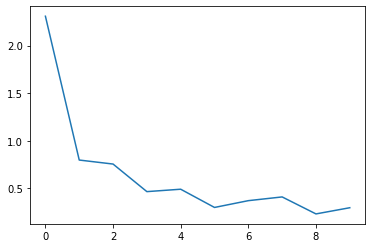

In [12]:
plt.plot(loss_arr)
plt.show()

## 9.테스트 하기 

In [ ]:
correct=0
total=0

with torch.no_grad():
  for image,label in test_loader:
    x=image.to(device)
    y_=label.to(device)
    output=model.forward(x)
     #https://pytorch.org/docs/stable/torch.html?highlight=max#torch.max
    _,output_index=torch.max(output,1)  #max함수는 max value와 max value의 index를 도출합니다. 두 번째 인자 1은 결과의 dimension을 의미합니다. 

    total+=label.size(0)

    correct += (output_index==y_).sum().float()

print("Accuracy of Test Data: {}%".format(100*correct/total))


Accuracy of Test Data: 94.29086303710938%


# 추가 섹션! cnn2d의 여러 파라미터를 알아봅시다 

- https://pytorch.org/docs/stable/nn.html?highlight=conv2d#torch.nn.Conv2d
- in_channels: 입력의 채널 수
- out_channels: 출력의 채널 수
- kernel_size: 필터 혹은 커널의 크기 
- stride: 필터 적용의 간격 (stride: 걸음걸이)
- padding: 입력 데이터를 추가적으로 둘러싸는 층의 두께
- padding_mode: 패딩 적용 방식 (ex. zero padding은 0으로 채우는 경우)



데이터는 위에서 불러들인 mnist_test를 그대로 이용합니다. 

In [ ]:
print(mnist_train)

# dataset.__getitem__(idx)
image,label = mnist_train.__getitem__(0)
print(image.size(),label)

#위 아래 모두 동일한 결과물을 도출합니다. 

# dataset[idx]
image,label = mnist_train[0]
print(image.size(),label)

# dataset.__len__()
print(mnist_train.__len__())

#위 아래 모두 동일한 결과물을 도출합니다. 

# len(dataset)
len(mnist_train)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([1, 28, 28]) 5
torch.Size([1, 28, 28]) 5
60000


60000

## 데이터 시각화 

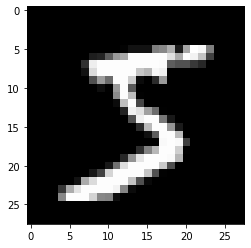

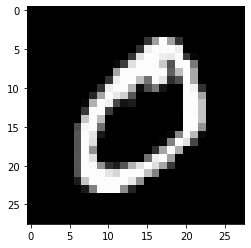

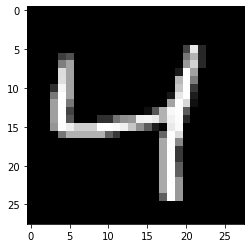

In [ ]:
for i in range(3):
    img= mnist_train[i][0].numpy()
    plt.imshow(img[0],cmap='gray')
    plt.show()

- 파이토치 텐서 사이즈는 다음과 같은 형태를 가지고 있습니다 -> [Batch,Channel,Height,Width]


## 1) Channels



torch.Size([1, 3, 28, 28])


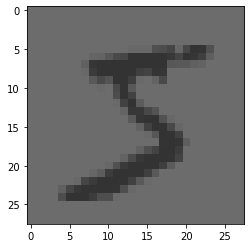

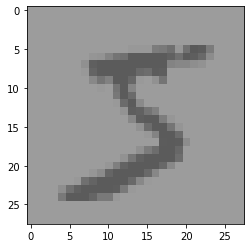

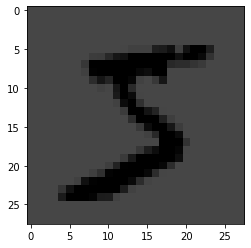

In [ ]:
# 먼저 트레이닝 데이터의 첫번째 이미지-라벨 쌍을 불러옵니다.
image,label = mnist_train[0]

# nn.Conv2d 연산을 적용할 수 있도록 이미지 데이터의 형태를 [1,1,28,28]로 만들어줍니다.
# 이 데이터의 경우 데이터 하나가 원래 [1,28,28]의 크기를 가진 흑백데이터입니다.  
# [batch,channel,h,w]의 크기를 가져야 하기 때문에 이렇게 바꾸어줬습니다. 
# 이는 view 말고도 unsqueeze 함수로도 구현할 수 있습니다.
image = image.view(-1,image.size()[0],image.size()[1],image.size()[2])

# 1개의 채널을 입력으로 받아서 3개의 채널이 나오는 컨볼루션 연산을 정의합니다.
conv_layer = nn.Conv2d(in_channels=1,out_channels=3,kernel_size=1)

#3개의 채널이 나온다는 것은 3개의 feature map이 나온다는 것과 동일합니다. 

# 연산에 입력 이미지를 넣습니다.
output = conv_layer(image)

# 결과의 형태를 확인합니다. 
# 연산에서 정의한대로 결과값의 형태는 [1,3,28,28]이 나옵니다. 

print(output.size())

# 출력의 각 채널별 이미지를 띄워봅니다. 
for i in range(output.size()[1]):
    plt.imshow(output[0,i,:,:].data.numpy(),cmap='gray',vmin=-1,vmax=1)
    plt.show()

### 2) Kernel Size


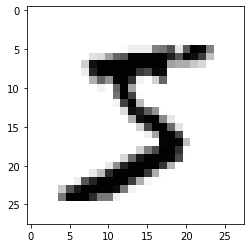

커널 사이즈가 1인 경우 결과값의 크기:torch.Size([1, 1, 28, 28])


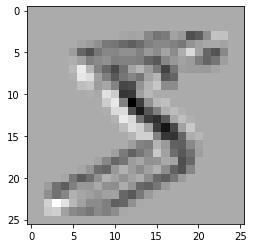

커널 사이즈가 3인 경우 결과값의 크기:torch.Size([1, 1, 26, 26])


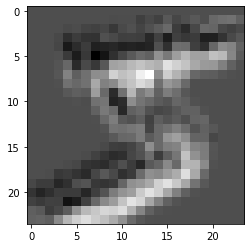

커널 사이즈가 5인 경우 결과값의 크기:torch.Size([1, 1, 24, 24])


In [ ]:
# 커널 사이즈를 1로 하는 경우
conv_layer = nn.Conv2d(in_channels=1,out_channels=1,kernel_size=1)
output = conv_layer(image)
plt.imshow(output[0,0,:,:].data.numpy(),cmap='gray')
plt.show()
print("커널 사이즈가 1인 경우 결과값의 크기:{}".format(output.size()))


# 커널 사이즈를 3로 하는 경우
conv_layer = nn.Conv2d(in_channels=1,out_channels=1,kernel_size=3)
output = conv_layer(image)
plt.imshow(output[0,0,:,:].data.numpy(),cmap='gray')
plt.show()
print("커널 사이즈가 3인 경우 결과값의 크기:{}".format(output.size()))


# 커널 사이즈를 5로 하는 경우
conv_layer = nn.Conv2d(in_channels=1,out_channels=1,kernel_size=5)
output = conv_layer(image)
plt.imshow(output[0,0,:,:].data.numpy(),cmap='gray')
plt.show()
print("커널 사이즈가 5인 경우 결과값의 크기:{}".format(output.size()))

## 3) Stride

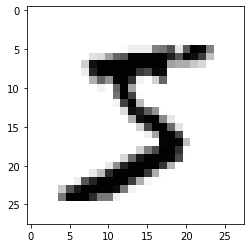

스트라이드가 1인 경우 결과값의 크기:torch.Size([1, 1, 28, 28])


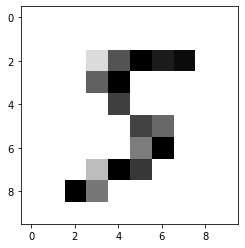

스트라이드가 3인 경우 결과값의 크기:torch.Size([1, 1, 10, 10])


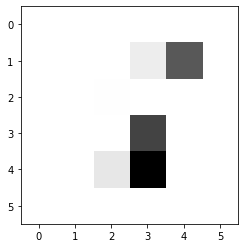

스트라이드가 5인 경우 결과값의 크기:torch.Size([1, 1, 6, 6])


In [ ]:
# 스트라이드가 1인 경우
conv_layer = nn.Conv2d(in_channels=1,out_channels=1,kernel_size=1,stride=1)
output = conv_layer(image)
plt.imshow(output[0,0,:,:].data.numpy(),cmap='gray')
plt.show()
print("스트라이드가 1인 경우 결과값의 크기:{}".format(output.size()))


# 스트라이드가 3인 경우
conv_layer = nn.Conv2d(in_channels=1,out_channels=1,kernel_size=1,stride=3)
output = conv_layer(image)
plt.imshow(output[0,0,:,:].data.numpy(),cmap='gray')
plt.show()
print("스트라이드가 3인 경우 결과값의 크기:{}".format(output.size()))


# 스트라이드가 5인 경우
conv_layer = nn.Conv2d(in_channels=1,out_channels=1,kernel_size=1,stride=5)
output = conv_layer(image)
plt.imshow(output[0,0,:,:].data.numpy(),cmap='gray')
plt.show()
print("스트라이드가 5인 경우 결과값의 크기:{}".format(output.size()))

## 4) Padding

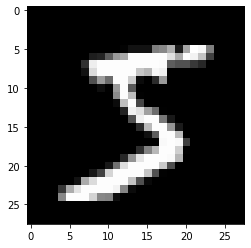

패딩이 0인 경우 결과값의 크기:torch.Size([1, 1, 28, 28])


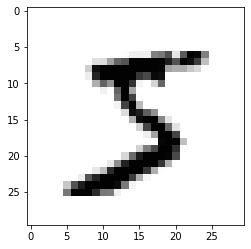

패딩이 1인 경우 결과값의 크기:torch.Size([1, 1, 30, 30])


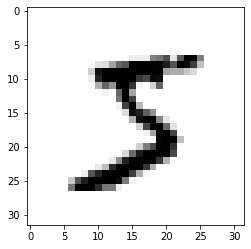

패딩이 2인 경우 결과값의 크기:torch.Size([1, 1, 32, 32])


In [ ]:
# 패딩이 없는 경우
conv_layer = nn.Conv2d(in_channels=1,out_channels=1,kernel_size=1,padding=0)
output = conv_layer(image)
plt.imshow(output[0,0,:,:].data.numpy(),cmap='gray')
plt.show()
print("패딩이 0인 경우 결과값의 크기:{}".format(output.size()))

# 패딩이 1인 경우
conv_layer = nn.Conv2d(in_channels=1,out_channels=1,kernel_size=1,padding=1)
output = conv_layer(image)
plt.imshow(output[0,0,:,:].data.numpy(),cmap='gray')
plt.show()
print("패딩이 1인 경우 결과값의 크기:{}".format(output.size()))

# 패딩이 2인 경우
conv_layer = nn.Conv2d(in_channels=1,out_channels=1,kernel_size=1,padding=2)
output = conv_layer(image)
plt.imshow(output[0,0,:,:].data.numpy(),cmap='gray')
plt.show()
print("패딩이 2인 경우 결과값의 크기:{}".format(output.size()))